This code uses seeds for easy replication of results.

In [1]:
#Import Statements
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import librosa.display
from librosa.feature import mfcc
from librosa.feature import melspectrogram
import time

In [2]:
# Local Variables
# If you sync your google drive with your hard drive, you should be able to make everything work
# by just changing the drive directory.
drive_directory = "E:\\Google Drive\\Big Data Project - Group 20"
notebook_directory = drive_directory + "\\Code\\Sukris\\features-10_accuracy-81"
audio_directory = drive_directory + "\\genres"
model_directory = notebook_directory + "\\model"
sample_rate = 22050

# Tuning Variables
genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
train_split = 0.8 # Percentage of data that will be used to train
segment_width = 0.2 # Length of each audio segment in seconds
num_frequencies = 128 # Number of frequency bins
max_frequency = 4000 # Frequencies above this value will not be included
num_epochs = 10 # Number of epochs to train with
training_data_used = 1.0 # Percentage of the training data that is used
test_data_used = 1.0 # Percentage of the test data that is used
seed_np = 0 # Seed used for randomizing train/test split
seed_tf = 4 # Seed used for randomizing tensorflow

In [3]:
t1 = time.time()

# Load data from audio directory
features = []
classes = []
framerates = []

# Changes an int to a string of some length l, padded with 0s in front of it. For example:
# Inputs: n = 16, l = 5
# Output: "00016"
def num_to_str(n,l):
    output = ''
    n = str(n)
    if len(n) > l:
        return None
    for i in range(l-len(n)):
        output += '0'
    
    return output + n

# Full audio data
print("Loading data...")
k = len(genres)
extension = '.wav'
#Get  Audio Data
for g in tqdm(range(len(genres))):
    genre = genres[g]
    new_dir = audio_directory + '\\' + genre
    genre_features = []
    for n in range(100):
        num = num_to_str(n,5)
        file_name = genre + '.' + num + extension
        file_path = new_dir + '\\' + file_name
        frames,_ = librosa.load(file_path, sr=sample_rate)
        
        genre_features.append(frames)
    features.append(genre_features)

t2 = time.time()
time_loading = t2-t1

Loading data...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.52s/it]


In [4]:
t1 = time.time()

# Seed for reproducability
np.random.seed(seed_np)

# Separate full audio into training and test data
training_features_full = []
training_classes_full = []
test_features_full = []
test_classes_full = []
for n in tqdm(range(len(features))):
    
    # Shuffle data
    key = np.arange(len(features[n]))
    np.random.shuffle(key)

    # Separate Data
    total = len(features[n])
    num_training_samples = int(total * train_split)
    num_test_samples = total - num_training_samples
    
    for m in range(num_training_samples):
        training_features_full.append(features[n][key[m]])
        training_classes_full.append(n)

    for m in range(num_test_samples):
        test_features_full.append(features[n][key[m + num_training_samples]])
        test_classes_full.append(n)

print("Number of training features:", len(training_features_full))
print("Number of testing features: ", len(test_features_full))

t2 = time.time()
time_train_test_split = t2-t1


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10029.42it/s]


Number of training features: 800
Number of testing features:  200


In [5]:
t1 = time.time()

# Segment data
num_seconds = segment_width
sample_size = int(sample_rate * num_seconds)

print("Segmenting training data...")
# Segment training data
training_features_segmented = []
training_classes_segmented = []
for n in tqdm(range(len(training_classes_full))):
    c = 0
    while True:
        frames = training_features_full[n]
        start = c * sample_size
        end = start + sample_size
        if end >= len(frames) * training_data_used:
            break
        training_features_segmented.append(frames[start:end])
        training_classes_segmented.append(training_classes_full[n])
        c += 1

print("Segmenting testing data...")
# Segment testing data
testing_features_segmented = []
testing_classes_segmented = []
for n in tqdm(range(len(test_classes_full))):
    segments = []
    c = 0
    while True:
        frames = test_features_full[n]
        start = c * sample_size
        end = start + sample_size
        if end >= len(frames) * test_data_used:
            break
        segments.append(frames[start:end])
        c += 1
    testing_features_segmented.append(np.array(segments))
    
t2 = time.time()
time_segmentation = t2-t1

Segmenting training data...


100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 8443.70it/s]


Segmenting testing data...


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 801.15it/s]


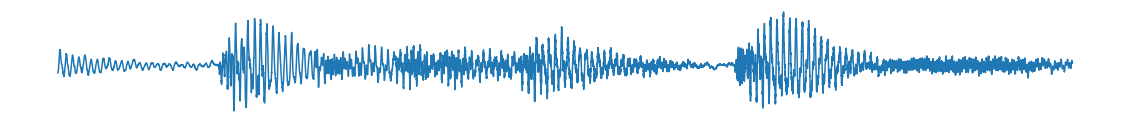

In [6]:
# Make a plot of a segment
os.chdir(notebook_directory)
x = []
for n in range(5,12):
    for i in range(len(training_features_segmented[n])):
        x.append(training_features_segmented[n][i])
plt.figure(figsize=[20,2])
plt.axis('off')
plt.plot(x)
# plt.savefig("raw_audio.png")

In [7]:
t1 = time.time()

# Get mfcc of testing samples
print("Taking MFCC of test features...")
testing_features_mfcc = []
for f in tqdm(testing_features_segmented):
    segments = []
    for s in f:
        segments.append(mfcc(y=s, sr=sample_rate, n_mfcc=num_frequencies, fmax=max_frequency).tolist())
    testing_features_mfcc.append(segments)

# Get mfcc of training samples
print("Taking MFCC of training features...")
training_features_mfcc = []
for f in tqdm(training_features_segmented):
    training_features_mfcc.append(mfcc(y=f, sr=sample_rate,n_mfcc=num_frequencies,fmax=max_frequency).tolist())

print("Training features shape:",np.shape(training_features_mfcc))
print("Testing features shape: ",np.shape(testing_features_mfcc))

t2 = time.time()
time_mfcc = t2-t1

Taking MFCC of test features...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:42<00:00,  1.84it/s]


Taking MFCC of training features...


100%|█████████████████████████████████████████████████████████████████████████| 120039/120039 [06:47<00:00, 294.91it/s]


Training features shape: (120039, 128, 9)
Testing features shape:  (200,)


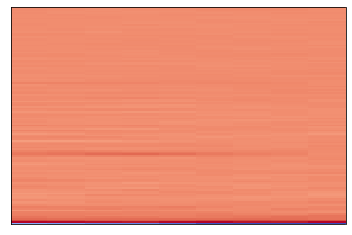

In [8]:
librosa.display.specshow(np.array(training_features_mfcc[5]))
# plt.savefig("mfcc_0.jpg")

In [9]:
t1 = time.time()

# Define Segment Model
tf.random.set_seed(seed_tf)
shape = np.shape(training_features_mfcc[0])
n = shape[0]*shape[1]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=shape))
model.add(tf.keras.layers.Dense(n,activation='elu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(int(n/2),activation='elu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(n/4,activation='elu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(int(n/8),activation='elu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(int(n/16),activation='elu'))
model.add(tf.keras.layers.Dense(k, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Fit segment model
print("Initializing model...")
output_fit = model.fit(training_features_mfcc, training_classes_segmented, epochs=num_epochs, verbose=2)

t2 = time.time()
time_fit = t2-t1

Initializing model...
Train on 120039 samples
Epoch 1/10
120039/120039 - 38s - loss: 1.4320 - accuracy: 0.5192
Epoch 2/10
120039/120039 - 36s - loss: 1.0104 - accuracy: 0.6668
Epoch 3/10
120039/120039 - 36s - loss: 0.8847 - accuracy: 0.7271
Epoch 4/10
120039/120039 - 37s - loss: 0.6882 - accuracy: 0.7786
Epoch 5/10
120039/120039 - 38s - loss: 0.5948 - accuracy: 0.8124
Epoch 6/10
120039/120039 - 37s - loss: 0.7672 - accuracy: 0.8167
Epoch 7/10
120039/120039 - 37s - loss: 0.5012 - accuracy: 0.8442
Epoch 8/10
120039/120039 - 37s - loss: 0.5221 - accuracy: 0.8552
Epoch 9/10
120039/120039 - 37s - loss: 0.4030 - accuracy: 0.8767
Epoch 10/10
120039/120039 - 37s - loss: 0.3847 - accuracy: 0.8851


In [10]:
# Compute segment accuracy
num_correct = 0
total = 0
c = -1
counts = np.zeros(len(genres))
totals = np.zeros(len(genres))
for a in tqdm(testing_features_mfcc):
    c += 1
    segment_predictions = model.predict(a)
    for p in segment_predictions:
        predicted_class = np.argmax(p)
        actual_class = test_classes_full[c]
        total += 1
        totals[actual_class] += 1
        if predicted_class == actual_class:
            num_correct += 1
            counts[actual_class] += 1
            

segment_accuracy = num_correct/total
segment_accuracies = counts/totals
print("Segment accuracy:",segment_accuracy)
print()
for n in range(len(genres)):
    print(genres[n], segment_accuracies[n])
print()
print(np.sum(counts)/np.sum(totals))


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:55<00:00,  3.64it/s]


Segment accuracy: 0.5384743559836038

blues 0.6073333333333333
classical 0.8073975341552816
country 0.49133333333333334
disco 0.3955348217260913
hiphop 0.4275241586137954
jazz 0.6537949400798935
metal 0.567
pop 0.5033333333333333
reggae 0.507
rock 0.42433333333333334

0.5384743559836038


In [11]:
# Predict test model using equal voting
# Testing features shape: (a,b,c,d)
# a: Number of samples
# b: Number of segments
# c: First dimension of mfcc
# d: Second dimension of mfcc

t1 = time.time()

print("Evaluating model...")
predictions = []
distributions = []
for a in tqdm(testing_features_mfcc):
    counts = np.zeros(k,dtype=int)
    segment_predictions = np.argmax(model.predict(a), axis=1)
    for p in segment_predictions:
        counts[p] += 1
    distributions.append(counts)
    predictions.append(np.argmax(counts))

distributions = np.array(distributions)
predictions = np.array(predictions)
truth = (predictions == test_classes_full)
accuracy = np.sum(truth)/len(predictions)
confidence = np.round(distributions/np.sum(distributions,axis=1)[:,np.newaxis],2)

t2 = time.time()
time_predict = t2-t1

print("Testing accuracy:", accuracy)
print("Testing time:    ", time_predict)

Evaluating model...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:55<00:00,  3.66it/s]


Testing accuracy: 0.81
Testing time:     55.65118956565857


0.6287037037037037 0.21252781630255357
0.38894736842105265 0.12443111545379153


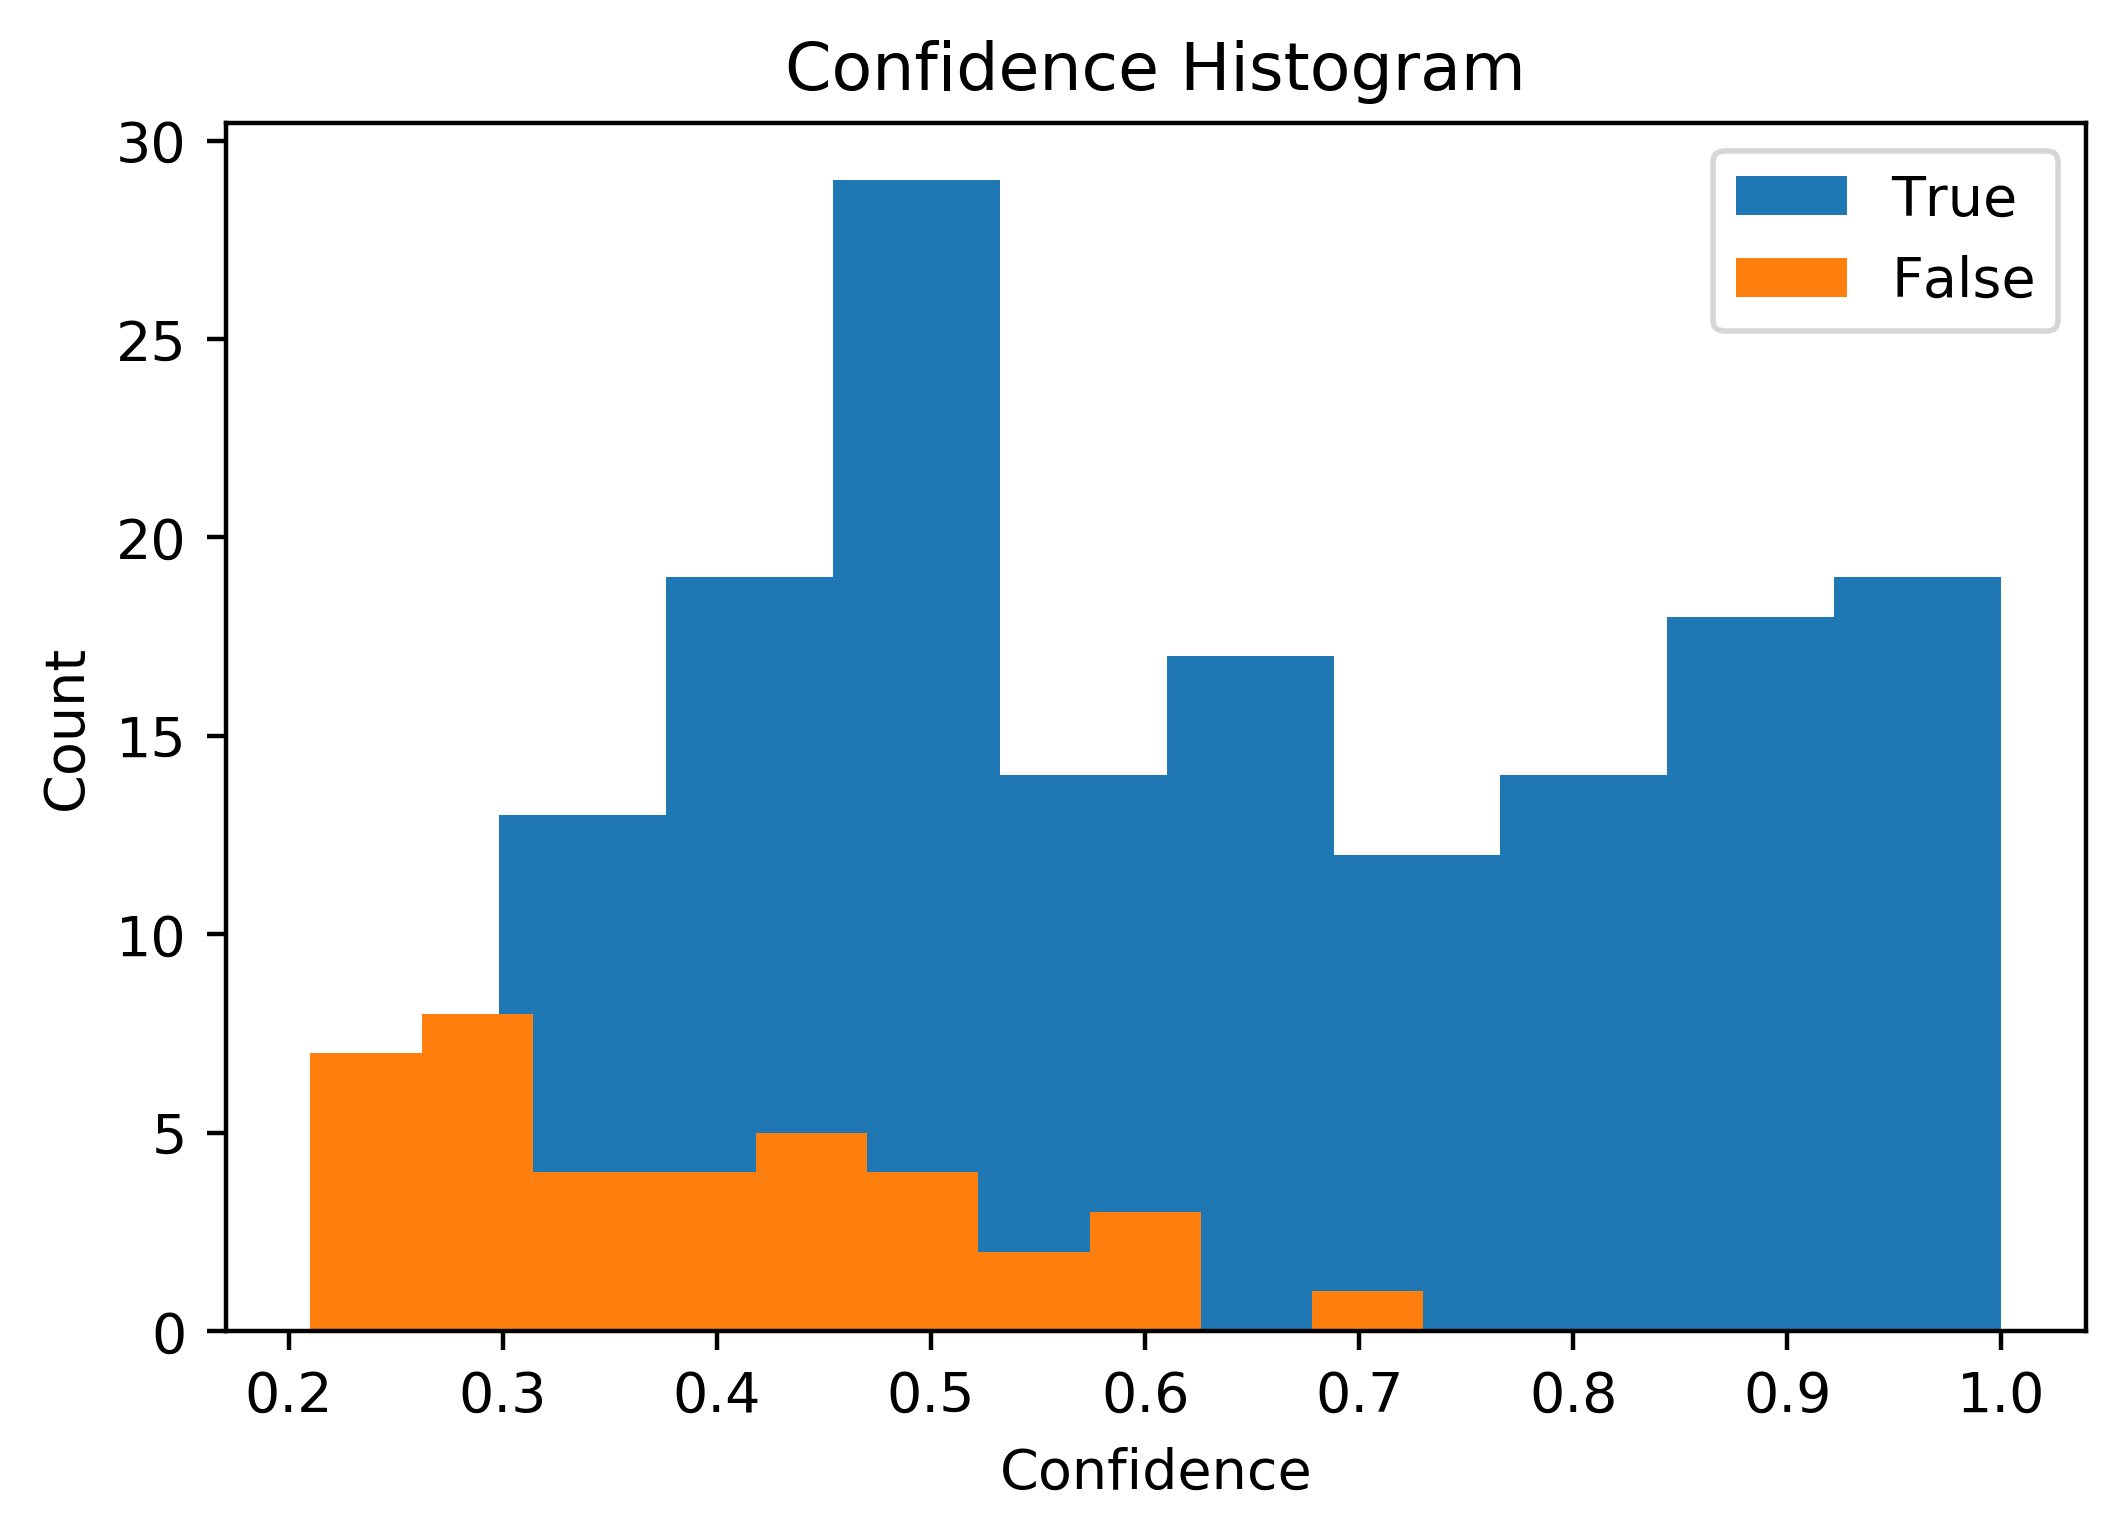

In [12]:
# Calculate accuracies
counts = np.zeros(len(genres))
totals = np.zeros(len(genres),dtype=int)
for n in range(len(test_classes_full)):
    c = test_classes_full[n]
    totals[c] += 1
    if predictions[n] == c:
        counts[c] += 1
accuracy_g = counts/totals

# Calculate confidences
true_confidences = []
false_confidences = []
for n in range(len(truth)):
    if truth[n]:
        true_confidences.append(np.max(confidence[n]))
    else:
        false_confidences.append(np.max(confidence[n]))

true_confidences = np.array(true_confidences)
false_confidences = np.array(false_confidences)
        
# Calculate average confidences
true_mean = np.average(true_confidences)
true_std = np.std(true_confidences)
false_mean = np.average(false_confidences)
false_std = np.std(false_confidences)

print(true_mean,true_std)
print(false_mean,false_std)

plt.figure(dpi=400)
plt.hist(true_confidences)
plt.hist(false_confidences)
plt.title("Confidence Histogram")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.legend(["True","False"])
plt.savefig("histogram")
plt.show()

In [13]:
# Predict test model using weighted voting
# Testing features shape: (a,b,c,d)
# a: Number of samples
# b: Number of segments
# c: First dimension of mfcc
# d: Second dimension of mfcc

t1 = time.time()

print("Evaluating model...")
predictions = []
distributions = []
for a in tqdm(testing_features_mfcc):
    counts = np.zeros(k)
    segment_confidences = np.max(model.predict(a), axis=1)
    segment_predictions = np.argmax(model.predict(a), axis=1)
    for n in range(len(segment_predictions)):
        counts[segment_predictions[n]] += segment_confidences[n]
    distributions.append(counts)
    predictions.append(np.argmax(counts))

distributions = np.array(distributions)
predictions = np.array(predictions)
truth = (predictions == test_classes_full)
weighted_accuracy = np.sum(truth)/len(predictions)
confidence = np.round(distributions/np.sum(distributions,axis=1)[:,np.newaxis],2)

t2 = time.time()
time_predict = t2-t1

print("Testing accuracy:", weighted_accuracy)
print("Testing time:    ", time_predict)

Evaluating model...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:50<00:00,  1.79it/s]


Testing accuracy: 0.81
Testing time:     110.81377005577087


0.662962962962963 0.21255032487287928
0.4144736842105263 0.13482341996343633


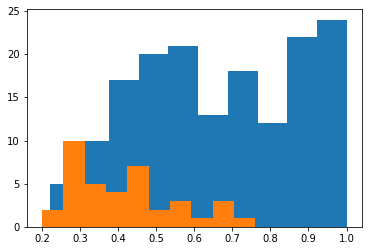

In [14]:
# Calculate accuracies
counts = np.zeros(len(genres))
totals = np.zeros(len(genres),dtype=int)
for n in range(len(test_classes_full)):
    c = test_classes_full[n]
    totals[c] += 1
    if predictions[n] == c:
        counts[c] += 1
accuracy_g = counts/totals

# Calculate confidences
true_confidences = []
false_confidences = []
for n in range(len(truth)):
    if truth[n]:
        true_confidences.append(np.max(confidence[n]))
    else:
        false_confidences.append(np.max(confidence[n]))

true_confidences = np.array(true_confidences)
false_confidences = np.array(false_confidences)
        
# Calculate average confidences
true_mean = np.average(true_confidences)
true_std = np.std(true_confidences)
false_mean = np.average(false_confidences)
false_std = np.std(false_confidences)

print(true_mean,true_std)
print(false_mean,false_std)

plt.figure()
plt.hist(true_confidences)
plt.hist(false_confidences)
plt.show()

In [15]:
# Show data
print("#============ Model Information ============#")
print("Genres:",genres)
print("Training percentage: ",train_split)
print("Segment width:       ",segment_width)
print("Number of frequencies",num_frequencies)
print("Maximum frequency    ",max_frequency)
print("Number of epochs     ",num_epochs)
print("Seed np:             ",seed_np)
print("Seed tf:             ",seed_tf)
print()

print("#============ Accuracy Information ============#")
print("Overall Accuracy: ", accuracy)
print("Weighted Accuracy:", weighted_accuracy)
print("Segment Accuracy: ", segment_accuracy)
print("True Confidence:  ", true_mean, true_std)
print("False Confidence: ", false_mean, false_std)

print()
for n in range(len(genres)):
    print(genres[n],"accuracy:",accuracy_g[n])
print()

print("#============ Timing Information Raw ============#")
t1 = np.round(time_loading,2)
t2 = np.round(time_train_test_split,2)
t3 = np.round(time_segmentation,2)
t4 = np.round(time_mfcc,2)
t5 = np.round(time_fit,2)
t6 = np.round(time_predict,2)
print("Data loading:    ",t1,"seconds")
print("Train/Test Split:",t2,"seconds")
print("Segmentation:    ",t3,"seconds")
print("Applying MFCC:   ",t4,"seconds")
print("Fitting Model:   ",t5,"seconds")
print("Predictions:     ",t6,"seconds")
print()

print("#============ Timing Information Condensed ============#")
print("Pre-Processing:",t1+t2+t3+t4,"seconds")
print("Training Time: ",t5,"seconds")
print("Testing Time:  ",t6,"seconds")

#============ Model Information ============#
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Training percentage:  0.8
Segment width:        0.2
Number of frequencies 128
Maximum frequency     4000
Number of epochs      10
Seed np:              0
Seed tf:              4

#============ Accuracy Information ============#
Overall Accuracy:  0.81
Weighted Accuracy: 0.81
Segment Accuracy:  0.5384743559836038
True Confidence:   0.662962962962963 0.21255032487287928
False Confidence:  0.4144736842105263 0.13482341996343633

blues accuracy: 0.85
classical accuracy: 0.95
country accuracy: 0.85
disco accuracy: 0.75
hiphop accuracy: 0.75
jazz accuracy: 0.95
metal accuracy: 0.7
pop accuracy: 0.8
reggae accuracy: 0.7
rock accuracy: 0.8

#============ Timing Information Raw ============#
Data loading:     16.03 seconds
Train/Test Split: 0.05 seconds
Segmentation:     0.35 seconds
Applying MFCC:    518.26 seconds
Fitting Model:    660.15 seconds

In [16]:
# Look at what's wrong
for n in range(len(truth)):
    if truth[n]:
        continue
    print("Predicted: ",predictions[n], genres[predictions[n]])
    print("Actual:    ",test_classes_full[n], genres[test_classes_full[n]])
    print("Confidence:",confidence[n])
    print()

Predicted:  3 disco
Actual:     0 blues
Confidence: [0.08 0.   0.   0.39 0.01 0.01 0.02 0.31 0.12 0.06]

Predicted:  5 jazz
Actual:     0 blues
Confidence: [0.12 0.2  0.   0.   0.03 0.28 0.   0.05 0.17 0.13]

Predicted:  2 country
Actual:     0 blues
Confidence: [0.09 0.2  0.51 0.02 0.01 0.07 0.   0.03 0.01 0.07]

Predicted:  5 jazz
Actual:     1 classical
Confidence: [0.11 0.12 0.14 0.15 0.   0.29 0.   0.04 0.01 0.13]

Predicted:  9 rock
Actual:     2 country
Confidence: [0.17 0.   0.12 0.03 0.01 0.09 0.01 0.08 0.21 0.27]

Predicted:  5 jazz
Actual:     2 country
Confidence: [0.03 0.01 0.03 0.04 0.01 0.66 0.   0.01 0.17 0.04]

Predicted:  9 rock
Actual:     2 country
Confidence: [0.06 0.   0.35 0.03 0.01 0.03 0.07 0.   0.06 0.38]

Predicted:  2 country
Actual:     3 disco
Confidence: [0.01 0.   0.46 0.24 0.   0.01 0.01 0.11 0.05 0.12]

Predicted:  7 pop
Actual:     3 disco
Confidence: [0.01 0.   0.07 0.2  0.08 0.04 0.09 0.31 0.01 0.19]

Predicted:  7 pop
Actual:     3 disco
Confidence

In [17]:
'''
# Save model
model.summary()
tf.saved_model.save(model, model_directory)
'''

'\n# Save model\nmodel.summary()\ntf.saved_model.save(model, model_directory)\n'

In [18]:
'''
os.chdir(notebook_directory)
np.savez("training_features.npz",training_features_mfcc)
np.savez("training_classes.npz",training_classes_segmented)
np.savez("testing_features.npz",testing_features_mfcc)
np.savez("testing_classes.npz",test_classes_full)
'''

'\nos.chdir(notebook_directory)\nnp.savez("training_features.npz",training_features_mfcc)\nnp.savez("training_classes.npz",training_classes_segmented)\nnp.savez("testing_features.npz",testing_features_mfcc)\nnp.savez("testing_classes.npz",test_classes_full)\n'